In [373]:
# Notes for user:
# This notebook will use the dataset COVID-19 and forex to predict the forex spot price of a currency pair.
# What to ask user before using this application:
# What currency pair are you interested in? USD/GBP (This layout means that the base currency is USD)
# The currency the user wants to look at is how much the USD is worth to the GBP.
# Therefore, we look at the death rates in the US and the UK.


# Use some functions from tensorflow_docs
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-qabijevd
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-qabijevd
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0d41eeb858e80108db8d13ba25867757d7de0fcf9_-cp36-none-any.whl size=124709 sha256=347e8e983c15051ec1b935bc96c8d7bfa350c4c2c93d1767575c9fc791941f28
  Stored in directory: /tmp/pip-ephem-wheel-cache-mftbdani/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [374]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [375]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

2.2.0


In [376]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [377]:
# Importing covid_dataset using pandas. Droping null values.
covid_dataset_data= pd.read_csv('covid.csv', na_values = "?", comment='\t', skipinitialspace=True)
covid_dataset = covid_dataset_data.copy()
# covid_dataset = covid_dataset.dropna()
covid_dataset.head()

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,tests_units,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
3,AFG,Asia,Afghanistan,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
4,AFG,Asia,Afghanistan,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


In [378]:
# Trying to isolate location/country based on currency in question
# We are looking at pound and sterling therefore need to isolate 'United Kingdom' & 'United States' in location column
# Problem: Informaiton prints up until 'Trinidad and Tobago' for some reason – can print 'Togo'. Therefore cannot print United Kingdom or United States
us_death_rates = covid_dataset.loc[covid_dataset.location=='United States', ['location', 'date', 'total_deaths', 'total_cases', 'cvd_death_rate']]
us_death_rates.head()

,location,date,total_deaths,total_cases,cvd_death_rate
26490,United States,2019-12-31,0.0,0.0,151.089
26491,United States,2020-01-01,0.0,0.0,151.089
26492,United States,2020-01-02,0.0,0.0,151.089
26493,United States,2020-01-03,0.0,0.0,151.089
26494,United States,2020-01-04,0.0,0.0,151.089


In [379]:
uk_death_rates.shape

(187, 5)

In [380]:
# us_death_rates = covid_dataset.loc[covid_dataset.location=='Zimbabwe', ['location', 'date', 'total_deaths','total_cases','cvd_death_rate']]
# us_death_rates.head()

In [381]:
us_death_rates.shape

(187, 5)

In [382]:
# Import forex
forex_dataset_data= pd.read_csv('GBP_USD.csv', na_values = "?", comment='\t', skipinitialspace=True)
forex_dataset = forex_dataset_data.copy()
# forex_dataset = forex_dataset_data.dropna()
# Filter dataset
forex_dataset.pop('Open')
forex_dataset.pop('High')
forex_dataset.pop('Low')
forex_dataset.pop('Change %')


0       0.12%
1      -0.05%
2       0.59%
3       0.83%
4      -0.30%
        ...  
150    -0.15%
151     0.40%
152     0.85%
153     0.44%
154     0.02%
Name: Change %, Length: 155, dtype: object

In [383]:
forex_dataset.tail()

,Date,Price
150,"Dec 06, 2019",1.3137
151,"Dec 05, 2019",1.3157
152,"Dec 04, 2019",1.3104
153,"Dec 03, 2019",1.2994
154,"Dec 02, 2019",1.2937


In [384]:
# Isolate covid_date
import time 
us_date = us_death_rates['date']
new_us_dates = [time.strptime(x.replace("-"," "), '%Y %m %d')for x in us_date]
us_death_rates['date'] = new_us_dates
us_death_rates.head()


,location,date,total_deaths,total_cases,cvd_death_rate
26490,United States,"(2019, 12, 31, 0, 0, 0, 1, 365, -1)",0.0,0.0,151.089
26491,United States,"(2020, 1, 1, 0, 0, 0, 2, 1, -1)",0.0,0.0,151.089
26492,United States,"(2020, 1, 2, 0, 0, 0, 3, 2, -1)",0.0,0.0,151.089
26493,United States,"(2020, 1, 3, 0, 0, 0, 4, 3, -1)",0.0,0.0,151.089
26494,United States,"(2020, 1, 4, 0, 0, 0, 5, 4, -1)",0.0,0.0,151.089


In [385]:
# Isolate forex_date
import time 
forex_date = forex_dataset['Date']
new_forex_dates = [time.strptime(x.replace(',', ""), '%b %d %Y')for x in forex_date]
forex_dataset['Date'] = new_forex_dates
forex_dataset.tail()

,Date,Price
150,"(2019, 12, 6, 0, 0, 0, 4, 340, -1)",1.3137
151,"(2019, 12, 5, 0, 0, 0, 3, 339, -1)",1.3157
152,"(2019, 12, 4, 0, 0, 0, 2, 338, -1)",1.3104
153,"(2019, 12, 3, 0, 0, 0, 1, 337, -1)",1.2994
154,"(2019, 12, 2, 0, 0, 0, 0, 336, -1)",1.2937


In [386]:
# Merging dates from two tables
dataset = pd.merge(left=forex_dataset, left_on='Date',
         right=us_death_rates, right_on='date')
dataset.tail()


,Date,Price,location,date,total_deaths,total_cases,cvd_death_rate
129,"(2020, 1, 6, 0, 0, 0, 0, 6, -1)",1.3169,United States,"(2020, 1, 6, 0, 0, 0, 0, 6, -1)",0.0,0.0,151.089
130,"(2020, 1, 3, 0, 0, 0, 4, 3, -1)",1.3088,United States,"(2020, 1, 3, 0, 0, 0, 4, 3, -1)",0.0,0.0,151.089
131,"(2020, 1, 2, 0, 0, 0, 3, 2, -1)",1.3146,United States,"(2020, 1, 2, 0, 0, 0, 3, 2, -1)",0.0,0.0,151.089
132,"(2020, 1, 1, 0, 0, 0, 2, 1, -1)",1.3255,United States,"(2020, 1, 1, 0, 0, 0, 2, 1, -1)",0.0,0.0,151.089
133,"(2019, 12, 31, 0, 0, 0, 1, 365, -1)",1.3261,United States,"(2019, 12, 31, 0, 0, 0, 1, 365, -1)",0.0,0.0,151.089


In [387]:
# We pop the 'date' from the covid_dataset because this column starts later than the forex column
# We want to see the forex price before covid happened
dataset.pop('date')

0        (2020, 7, 3, 0, 0, 0, 4, 185, -1)
1        (2020, 7, 2, 0, 0, 0, 3, 184, -1)
2        (2020, 7, 1, 0, 0, 0, 2, 183, -1)
3       (2020, 6, 30, 0, 0, 0, 1, 182, -1)
4       (2020, 6, 29, 0, 0, 0, 0, 181, -1)
                      ...                 
129        (2020, 1, 6, 0, 0, 0, 0, 6, -1)
130        (2020, 1, 3, 0, 0, 0, 4, 3, -1)
131        (2020, 1, 2, 0, 0, 0, 3, 2, -1)
132        (2020, 1, 1, 0, 0, 0, 2, 1, -1)
133    (2019, 12, 31, 0, 0, 0, 1, 365, -1)
Name: date, Length: 134, dtype: object

In [388]:
# Problem: This still starts at 2019,12,13 when we want 2019,12,02
# However this does not affect our data graph for some reason - scroll down
dataset.tail()

,Date,Price,location,total_deaths,total_cases,cvd_death_rate
129,"(2020, 1, 6, 0, 0, 0, 0, 6, -1)",1.3169,United States,0.0,0.0,151.089
130,"(2020, 1, 3, 0, 0, 0, 4, 3, -1)",1.3088,United States,0.0,0.0,151.089
131,"(2020, 1, 2, 0, 0, 0, 3, 2, -1)",1.3146,United States,0.0,0.0,151.089
132,"(2020, 1, 1, 0, 0, 0, 2, 1, -1)",1.3255,United States,0.0,0.0,151.089
133,"(2019, 12, 31, 0, 0, 0, 1, 365, -1)",1.3261,United States,0.0,0.0,151.089


In [389]:
# Object means string
dataset.dtypes

Date               object
Price             float64
location           object
total_deaths      float64
total_cases       float64
cvd_death_rate    float64
dtype: object

In [390]:
# View what date looks like
date = dataset['Date']
date.head()

0     (2020, 7, 3, 0, 0, 0, 4, 185, -1)
1     (2020, 7, 2, 0, 0, 0, 3, 184, -1)
2     (2020, 7, 1, 0, 0, 0, 2, 183, -1)
3    (2020, 6, 30, 0, 0, 0, 1, 182, -1)
4    (2020, 6, 29, 0, 0, 0, 0, 181, -1)
Name: Date, dtype: object

In [391]:
# Splitting timestamp and isolating the date
dateFormatting = pd.DataFrame({'my_timestamp': pd.date_range('2019-12-02 15:00', periods=len(date))})
dateFormatting['new_date'] = [d.date() for d in dateFormatting['my_timestamp']]
dateFormatting['new_time'] = [d.time() for d in dateFormatting['my_timestamp']]
print(dateFormatting)


           my_timestamp    new_date  new_time
0   2019-12-02 15:00:00  2019-12-02  15:00:00
1   2019-12-03 15:00:00  2019-12-03  15:00:00
2   2019-12-04 15:00:00  2019-12-04  15:00:00
3   2019-12-05 15:00:00  2019-12-05  15:00:00
4   2019-12-06 15:00:00  2019-12-06  15:00:00
..                  ...         ...       ...
129 2020-04-09 15:00:00  2020-04-09  15:00:00
130 2020-04-10 15:00:00  2020-04-10  15:00:00
131 2020-04-11 15:00:00  2020-04-11  15:00:00
132 2020-04-12 15:00:00  2020-04-12  15:00:00
133 2020-04-13 15:00:00  2020-04-13  15:00:00

[134 rows x 3 columns]


In [392]:
# Convert date to list so that we can use the dates to plot on graph
my_xticks = dateFormatting['new_date'].tolist()
print(my_xticks)

[datetime.date(2019, 12, 2), datetime.date(2019, 12, 3), datetime.date(2019, 12, 4), datetime.date(2019, 12, 5), datetime.date(2019, 12, 6), datetime.date(2019, 12, 7), datetime.date(2019, 12, 8), datetime.date(2019, 12, 9), datetime.date(2019, 12, 10), datetime.date(2019, 12, 11), datetime.date(2019, 12, 12), datetime.date(2019, 12, 13), datetime.date(2019, 12, 14), datetime.date(2019, 12, 15), datetime.date(2019, 12, 16), datetime.date(2019, 12, 17), datetime.date(2019, 12, 18), datetime.date(2019, 12, 19), datetime.date(2019, 12, 20), datetime.date(2019, 12, 21), datetime.date(2019, 12, 22), datetime.date(2019, 12, 23), datetime.date(2019, 12, 24), datetime.date(2019, 12, 25), datetime.date(2019, 12, 26), datetime.date(2019, 12, 27), datetime.date(2019, 12, 28), datetime.date(2019, 12, 29), datetime.date(2019, 12, 30), datetime.date(2019, 12, 31), datetime.date(2020, 1, 1), datetime.date(2020, 1, 2), datetime.date(2020, 1, 3), datetime.date(2020, 1, 4), datetime.date(2020, 1, 5), da

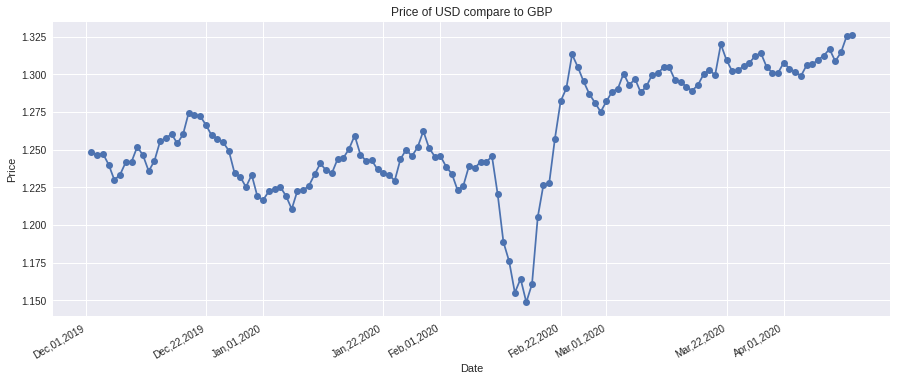

In [393]:
# Plotted prices and dates
# Notice how the dates start and end

from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates
plt.style.use('seaborn')
from matplotlib import rcParams
rcParams['figure.figsize'] = 15,6

dates = np.array(dateFormatting['new_date'])
price = np.array(dataset['Price'])
plt.plot_date(dates,price, linestyle ='solid')
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%b,%d,%Y')
plt.title('Price of USD compare to GBP')
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(date_format)

In [401]:
# Adds the accumulative deaths every day of a country
# Problem – This needs to be sorted from the end since the way out data is set up - can this be made more efficient?
# It works well for now
total_us_deaths = dataset['total_deaths']
list = np.array(total_us_deaths)
reversed_arr = list[::-1]
newDay = 0
day = []
for currentday in reversed_arr:
   newDay = currentday + newDay
   day.append(newDay)
print(day)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 8.0, 17.0, 28.0, 40.0, 61.0, 87.0, 115.0, 145.0, 185.0, 254.0, 339.0, 447.0, 597.0, 747.0, 1218.0, 1808.0, 2609.0, 3659.0, 4955.0, 7464.0, 10634.0, 14713.0, 19851.0, 25904.0, 35551.0, 46540.0, 59435.0, 74252.0, 90942.0, 113050.0, 136699.0, 162756.0, 193741.0, 227025.0, 267707.0, 310246.0, 355309.0, 402093.0, 452056.0, 506932.0, 563177.0, 621532.0, 682498.0, 745504.0, 813186.0, 882120.0, 953198.0, 1026629.0, 1102299.0, 1181827.0, 1262511.0, 1344898.0, 1429031.0, 1514937.0, 1604499.0, 1694852.0, 1786773.0, 1880212.0, 1974914.0, 2072634.0, 2170854.0, 2269770.0, 2370212.0, 2471829.0, 2576212.0, 2681359.0, 2787540.0, 2894715.0, 3002926.0, 3113440.0, 3224447.0, 3336453.0, 3449377.0, 3563197.0, 3678929.0, 3795056.0, 3912019.0, 4029736.0, 4148170.0, 4268145.0, 4388547.0, 

Text(0, 0.5, 'Total Deaths')

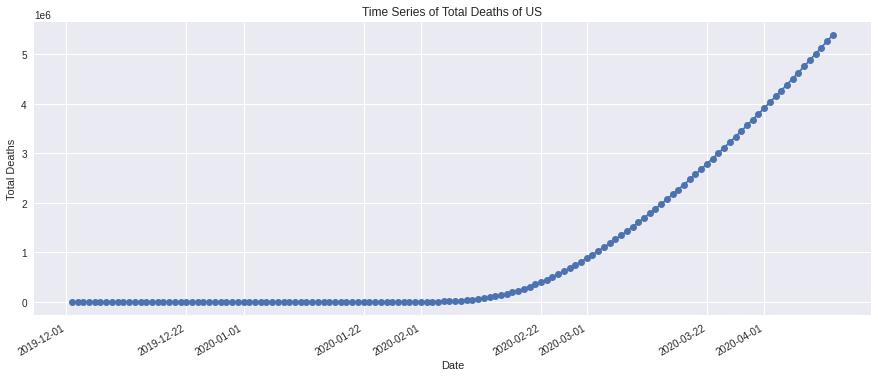

In [402]:
# Plots the accumulative daily death rates of a country
dates = np.array(dateFormatting['new_date'])
price = np.array(day)
plt.plot_date(dates,price, linestyle ='solid')
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%b,%d,%Y')
plt.title('Time Series of Total Deaths of US')
plt.xlabel('Date')
plt.ylabel('Total Deaths')


In [396]:
us_death_rates.pop('location')
us_death_rates.pop('date')

26490    (2019, 12, 31, 0, 0, 0, 1, 365, -1)
26491        (2020, 1, 1, 0, 0, 0, 2, 1, -1)
26492        (2020, 1, 2, 0, 0, 0, 3, 2, -1)
26493        (2020, 1, 3, 0, 0, 0, 4, 3, -1)
26494        (2020, 1, 4, 0, 0, 0, 5, 4, -1)
                        ...                 
26672     (2020, 6, 30, 0, 0, 0, 1, 182, -1)
26673      (2020, 7, 1, 0, 0, 0, 2, 183, -1)
26674      (2020, 7, 2, 0, 0, 0, 3, 184, -1)
26675      (2020, 7, 3, 0, 0, 0, 4, 185, -1)
26676      (2020, 7, 4, 0, 0, 0, 5, 186, -1)
Name: date, Length: 187, dtype: object

In [397]:
us_death_rates.shape

(187, 3)

In [398]:
# Rescaling data - Attempt at our data
# This method is not making sense
from sklearn import preprocessing
# need to sort out list – total deaths need to go up everyday
X = np.asarray(day)
# X = [us_death_rates['total_deaths'], us_death_rates['total_cases']]
X_scaled = preprocessing.scale(X)
X_scaled

array([-0.653, -0.653, -0.653, -0.653, -0.653, -0.653, -0.653, -0.653,
       -0.653, -0.653, -0.653, -0.653, -0.653, -0.653, -0.653, -0.653,
       -0.653, -0.653, -0.653, -0.653, -0.653, -0.653, -0.653, -0.653,
       -0.653, -0.653, -0.653, -0.653, -0.653, -0.653, -0.653, -0.653,
       -0.653, -0.653, -0.653, -0.653, -0.653, -0.653, -0.653, -0.653,
       -0.653, -0.653, -0.653, -0.653, -0.653, -0.653, -0.653, -0.653,
       -0.653, -0.653, -0.653, -0.653, -0.653, -0.653, -0.653, -0.653,
       -0.653, -0.653, -0.653, -0.653, -0.652, -0.652, -0.651, -0.65 ,
       -0.649, -0.647, -0.644, -0.641, -0.637, -0.631, -0.623, -0.615,
       -0.606, -0.595, -0.581, -0.566, -0.549, -0.529, -0.508, -0.481,
       -0.454, -0.425, -0.395, -0.363, -0.328, -0.292, -0.254, -0.215,
       -0.175, -0.131, -0.087, -0.041,  0.006,  0.054,  0.105,  0.157,
        0.21 ,  0.264,  0.319,  0.377,  0.435,  0.494,  0.554,  0.614,
        0.677,  0.74 ,  0.804,  0.868,  0.933,  1.   ,  1.068,  1.136,
      

In [399]:
# Rescaling data – Manual way of what we should we getting
# Values are far too high since we are working from the tail
# These values should appear between 0 and 1
var = day[-1]
X_train = (np.array(day)/var) * 100
ans = X_train/var
print(ans)

[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 6.878e-12 2.751e-11 5.847e-11 9.630e-11 1.376e-10
 2.098e-10 2.992e-10 3.955e-10 4.987e-10 6.362e-10 8.735e-10 1.166e-09
 1.537e-09 2.053e-09 2.569e-09 4.189e-09 6.218e-09 8.973e-09 1.258e-08
 1.704e-08 2.567e-08 3.657e-08 5.060e-08 6.827e-08 8.909e-08 1.223e-07
 1.601e-07 2.044e-07 2.554e-07 3.128e-07 3.888e-07 4.701e-07 5.597e-07
 6.663e-07 7.808e-07 9.207e-07 1.067e-06 1.222e-06 1.383e-06 1.555e-06
 1.743e-06 1.937e-06 2.138e-06 2.347e-06 2.564e-06 2.797e-06 3.034e-06
 3.278e-06 3.531e-06 3.791e-06 4.064e-06 4.342e-06 4.625e-06 4.915e-06
 5.210

In [403]:
# Whats the difference? 
# Now split the dataset into a training set and a test set.
# Now, we split the dataset into our input features and the label we wish to predict.
train_dataset = dataset.sample(frac=0.8,random_state=0)
# model.fit(death_rates,prices, epochs=10, validation_split=0.2)
# model.fit(train_x,train_y, epochs=10, validation_split=0.2)
train_dataset.tail()

,Date,Price,location,total_deaths,total_cases,cvd_death_rate
64,"(2020, 4, 6, 0, 0, 0, 0, 97, -1)",1.2230,United States,9647.0,337635.0,151.089
133,"(2019, 12, 31, 0, 0, 0, 1, 365, -1)",1.3261,United States,0.0,0.0,151.089
79,"(2020, 3, 16, 0, 0, 0, 0, 76, -1)",1.2268,United States,69.0,3774.0,151.089
69,"(2020, 3, 30, 0, 0, 0, 0, 90, -1)",1.2418,United States,2509.0,143025.0,151.089
80,"(2020, 3, 13, 0, 0, 0, 4, 73, -1)",1.2277,United States,40.0,1663.0,151.089


In [ ]:
# Looking at US first
# Split the data into train and test
# We will use our test set in the final evaluation of our model
test_dataset = dataset.drop(train_dataset.index)
test_dataset.tail()

In [ ]:
# Overall statistics
# Transpose: Row to collumn
# Calculated automatically mean and std
train_stats = train_dataset.describe()
train_stats.pop("Price")
train_stats = train_stats.transpose()
train_stats

In [ ]:
train_labels = train_dataset.pop('Price')
test_labels = test_dataset.pop('Price')

In [ ]:
# Building a model
# Let's build our model. Here, we'll use a Sequential model with 
# two densely connected hidden layers, and an output layer that 
# returns a single, continuous value. The model building steps are 
# wrapped in a function, build_model, since we'll create a 
# second model, later on.

def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])
# learning rate
  optimizer = tf.keras.optimizers.RMSprop(0.001)
  # WHAT IS THIS OPTIMIZER: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/RMSprop

# I will try to use the MSE- Mean Square Error and Mean Average error to minimise my losss
# 
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  # note: you are using the mae and mse, if you wanted to use a different optimizer you could use adam
  return model

In [ ]:
model = build_model()

In [ ]:
# Inspect the model
model.summary()

In [ ]:
# Take a batch of 10 examples from the training data and call model to predict on it.
# Does it produce a result of expected shape and type?
# Question: How do we know the shape?
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

In [ ]:
# Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.
# Mean Square Error: Measures every square error of our machine learning predictions
# Layout: Verbose = 0, can also do verbose = 1/2
# validation_split is a parameter that gets passed in. It's a number that determines how 
# your data should be partitioned into training and validation sets.
# For example if validation_split = 0.2 then 20% of your data will be used in the validation set 
# and 80% of your data will be used in the test set
# Meaning of this tabel:
# val_loss is the value of cost function for your cross-validation data and loss 
# is the value of cost function for your training data.

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])

In [ ]:
# Predicted output that we have
# Tensorfow puts everything in tensors
# Values are high due to normalisation
# What im trying to predict | What its giv
prediction = model.predict(test_dataset)
print(prediction)

In [ ]:
# What i should be predicting 
test_dataset.tail()
testDataList = test_labels.tolist()
# first number is index
# :middle: how many steps we want to take between each value
# end index. everything up until last 5 elements
print(testDataList[len(testDataList)-5::])


In [ ]:
# take away one from the other
# lines up at index they are
# extract as prediction and actual
# then find the difference 
# take 0th number of that list
# how far off we are off from our output
# note: v different from what forex should look like
for pred, actual in zip(prediction, testDataList):
  difference = pred.tolist()[0] - actual
  print(difference)

In [ ]:
# example of what zip does
l = [1,2,3,4]
s = [2,3,4,5]
print(list(zip(l,s)))

In [ ]:
# Visualize the model's training progress using the stats stored in the history object.
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

In [ ]:
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

In [ ]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]')

In [ ]:
# This graph shows little improvement, or even degradation in the validation 
# error after about 100 epochs. Let's update the model.fit call to automatically 
# stop training when the validation score doesn't improve. We'll use an 
# EarlyStopping callback that tests a training condition for every epoch. 
# If a set amount of epochs elapses without showing improvement, then 
# automatically stop the training.
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])

In [ ]:
#
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

In [ ]:
#
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

In [ ]:
# Make predictions
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [ ]:
#
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")